# Derive models of drone

Do all imports.

In [2]:
import sympy as sym
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import secrets
import ae353_drone


# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

pybullet build time: Sep  3 2024 12:57:43


## Dynamic model

Define physical parameters.

In [3]:
params = {
    'm': 0.5,
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.175,
    'g': 9.81,
}

Derive the equations of motion:

In [4]:
# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')
v_in_body = sym.Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')
w_in_body = sym.Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(params['m'])
Jx = sym.nsimplify(params['Jx'])
Jy = sym.nsimplify(params['Jy'])
Jz = sym.nsimplify(params['Jz'])
l = sym.nsimplify(params['l'])
g = sym.nsimplify(params['g'])
J = sym.diag(Jx, Jy, Jz)

# rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# applied forces
f_in_body = R_body_in_world.T @ sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

# applied torques
tau_in_body = sym.Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
f = sym.Matrix.vstack(
    R_body_in_world @ v_in_body,
    M @ w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() @ (tau_in_body - w_in_body.cross(J @ w_in_body)),
)

f = sym.simplify(f, full=True)

The equations of motion have this form:

$$\begin{bmatrix} \dot{p}_x \\ \dot{p}_y \\ \dot{p}_z \\ \dot{\psi} \\ \dot{\theta} \\ \dot{\phi} \\ \dot{v}_x \\ \dot{v}_y \\ \dot{v}_z \\ \dot{w}_x \\ \dot{w}_y \\ \dot{w}_z \end{bmatrix} = f\left(p_x, p_y, p_z, \psi, \theta, \phi, v_x, v_y, v_z, w_x, w_y, w_z, \tau_x, \tau_y, \tau_z, f_z \right)$$

Here is the function $f$:

In [5]:
f

Matrix([
[v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) - v_z*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))],
[                                                                      -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                                 (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                              w_y*cos(phi) - w_z*sin(phi)],
[                                                                                  w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                   v_y*w_z - v_z*w_y + 981*sin(theta)/100],
[   

## Sensor model

Define the sensor model.

In [6]:
# Position of drone in world frame
p_in_world = sym.Matrix([p_x, p_y, p_z])

# Position of markers in body frame
a_in_body = sym.Matrix([0, l, 0])  # <-- marker on left rotor
b_in_body = sym.Matrix([0, -l, 0]) # <-- marker on right rotor

# Position of markers in world frame
a_in_world = p_in_world + R_body_in_world @ a_in_body
b_in_world = p_in_world + R_body_in_world @ b_in_body

# Sensor model
g = sym.simplify(sym.Matrix.vstack(a_in_world, b_in_world))

The sensor model has this form:

$$o = g(p_x, p_y, p_z, \psi, \theta)$$

Here is the function $g$:

In [7]:
g

Matrix([
[p_x + 7*sin(phi)*sin(theta)*cos(psi)/40 - 7*sin(psi)*cos(phi)/40],
[p_y + 7*sin(phi)*sin(psi)*sin(theta)/40 + 7*cos(phi)*cos(psi)/40],
[                                  p_z + 7*sin(phi)*cos(theta)/40],
[p_x - 7*sin(phi)*sin(theta)*cos(psi)/40 + 7*sin(psi)*cos(phi)/40],
[p_y - 7*sin(phi)*sin(psi)*sin(theta)/40 - 7*cos(phi)*cos(psi)/40],
[                                  p_z - 7*sin(phi)*cos(theta)/40]])

In [8]:
from scipy.optimize import minimize
x = sym.Matrix([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z])
u = sym.Matrix([tau_x, tau_y, tau_z, f_z])

f_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z], [f])
f_num_for_minimize = lambda x: np.linalg.norm(np.array(f_num(*x)).flatten())**2

# Guess for the optimizer: all states and torques start at 0
x0_guess = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.905]

# Perform the minimization to find the equilibrium point
sol = minimize(f_num_for_minimize, x0_guess, tol=1e-8)

# Extract the equilibrium values from the solution
px_e = sol.x[0]
py_e = sol.x[1]
pz_e = sol.x[2]
psi_e = sol.x[3]
theta_e = sol.x[4]
phi_e = sol.x[5]
vx_e = sol.x[6]
vy_e = sol.x[7]
vz_e = sol.x[8]
wx_e = sol.x[9]
wy_e = sol.x[10]
wz_e = sol.x[11]
taux_e = sol.x[12]
tauy_e = sol.x[13]
tauz_e = sol.x[14]
fz_e = sol.x[15]

# Display the value of the dynamic equations at the found equilibrium (should be close to zero)
print(f_num(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.905))

# Print the computed equilibrium values
print(f' px_e = {px_e:7.3f}')
print(f'  py_e = {py_e:7.3f}')
print(f'  pz_e = {pz_e:7.3f}')
print(f'  psi_e = {psi_e:7.3f}')
print(f'  theta_e = {theta_e:7.3f}')
print(f' phi_e = {phi_e:7.3f}')
print(f' vx_e = {vx_e:7.3f}')
print(f'  vy_e = {vy_e:7.3f}')
print(f'  vz_e = {vz_e:7.3f}')
print(f' wx_e = {wx_e:7.3f}')
print(f'  wy_e = {wy_e:7.3f}')
print(f'  wz_e = {wz_e:7.3f}')
print(f'  taux_e = {taux_e:7.3f}')
print(f' tauy_e = {tauy_e:7.3f}')
print(f'  tauz_e = {tauz_e:7.3f}')
print(f' fz_e = {fz_e:7.3f}')

[array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])]
 px_e =   0.000
  py_e =   0.000
  pz_e =   0.000
  psi_e =   0.000
  theta_e =   0.000
 phi_e =   0.000
 vx_e =   0.000
  vy_e =   0.000
  vz_e =   0.000
 wx_e =   0.000
  wy_e =   0.000
  wz_e =   0.000
  taux_e =   0.000
 tauy_e =   0.000
  tauz_e =   0.000
 fz_e =   4.905


We now linearize the nonlinear dynamics around the equilibrium point to obtain the system matrices $A$ and $B$. We then design a continuous-time Linear Quadratic Regulator (LQR) to compute the optimal feedback gain matrix $K$. The rank of the controllability matrix is also checked to ensure that the linearized system is fully controllable.

In [9]:
from scipy import signal

# Use the equilibrium point as the linearization point
equil = x0_guess

# Compute Jacobian matrices A and B symbolically, then create lambdified versions
A_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z], f.jacobian([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]))
B_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z], f.jacobian([tau_x, tau_y, tau_z, f_z]))

# Evaluate A and B at the computed equilibrium point
A = A_num(px_e, py_e, pz_e, psi_e, theta_e, phi_e, vx_e, vy_e, vz_e, wx_e, wy_e, wz_e, taux_e, tauy_e, tauz_e, fz_e)
B = B_num(px_e, py_e, pz_e, psi_e, theta_e, phi_e, vx_e, vy_e, vz_e, wx_e, wy_e, wz_e, taux_e, tauy_e, tauz_e, fz_e)

# Define the LQR cost function matrices Q and R
# Qc prioritizes orientation errors over angular velocity (and makes control aggressive)
Qc = np.diag([5., 5., 1000., 5., 20., 20., 5., 5., 1000., 5., 20., 20.]) 
Rc = np.diag([10000., 10000., 10000., 10000.]) # R penalizes large control torques

# Solve the continuous-time Algebraic Riccati Equation (ARE)
P_c = linalg.solve_continuous_are(A, B, Qc, Rc)

# Compute the optimal state-feedback gain matrix K
K = linalg.inv(Rc) @  B.T @ P_c

# Check controllability: construct the controllability matrix
W = B
for i in range(1, A.shape[0]):
    W = np.block([W, np.linalg.matrix_power(A, i) @ B])

# Compute the rank of the controllability matrix
W_rank = np.linalg.matrix_rank(W)

# Compute the closed-loop system matrix
F = A - B@K

# Get eigenvalues of the closed-loop system
s = linalg.eigvals(F)

# Display the results
print(f"A = {A}")
print(f"B = {B}")
print((s.real < 0).all()) # Check if all eigenvalues have negative real parts (stable)
print(f"Matrix Rank of W: {W_rank}")
print(f"K = np.array({K})")

A = [[ 0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.    0.   -0.    0.    1.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.  ]
 [ 0.    0.    0.    0.    0.   -0.    0.    0.    0.    0.    1.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    9.81  0.    0.    0.   -0.    0.   -0.    0.  ]
 [ 0.    0.    0.    0.    0.   -9.81 -0.    0.    0.    0.    0.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.    0.   -0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]
B = [[  0.          0.          0.          0.       ]
 [  0.          0.          0.          

We compute the output matrix $C$ by taking the Jacobian of the sensor function $g$ with respect to the system state. This matrix is then evaluated at the equilibrium point to provide a linearized representation of the sensor model, which will be used in observer and estimator design.

In [10]:
# Create a lambdified function to compute the Jacobian of the sensor model g
# with respect to the state variables [psi, theta, phi, wx, wy, wz]
C_num = sym.lambdify([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z],g.jacobian([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]))

# Evaluate the output matrix C at the equilibrium point
C = C_num(px_e, py_e, pz_e, psi_e, theta_e, phi_e, vx_e, vy_e, vz_e, wx_e, wy_e, wz_e)

# Display the linearized sensor matrix
print(f"C = {C}")


C = [[ 1.     0.     0.    -0.175  0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     1.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.     1.     0.    -0.     0.175  0.     0.     0.     0.
   0.     0.   ]
 [ 1.     0.     0.     0.175 -0.    -0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     1.     0.     0.    -0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.     1.     0.     0.    -0.175  0.     0.     0.     0.
   0.     0.   ]]


To estimate the system state from sensor measurements, we design an observer gain matrix $L$. This gain is computed using the continuous-time algebraic Riccati equation (CARE), similar to how the feedback gain $K$ was derived. The observer dynamics are governed by the matrix $A-LC$, and we verify that all eigenvalues of this matrix have negative real parts to ensure stability.

In [11]:
from scipy.signal import place_poles
import control

# Define weighting matrices for observer design
Qo = np.diag([1.,1.,1.,1.,1.,1.]) # Penalizes estimation error
Ro = np.diag([1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.]) # Penalizes measurement noise

# Solve the continuous-time algebraic Riccati equation for observer design
P_o = linalg.solve_continuous_are(A.T, C.T, linalg.inv(Ro), linalg.inv(Qo))

# Compute the observer gain matrix L
L = (P_o @ C.T @ Qo)

# Observer error dynamics matrix
H = (A - L@C)

# Compute eigenvalues to check stability of the observer
s = linalg.eigvals(H)

# Confirm all eigenvalues have negative real parts (i.e., the observer is stable)
print((s.real < 0).all())

# Print the observer gain matrix
print(f"L = np.array({L})")

True
L = np.array([[ 2.97537602  0.          0.          2.97537602  0.         -0.        ]
 [ 0.          2.92711379 -0.21976816  0.          2.92711379  0.21976816]
 [ 0.          0.          1.09868411 -0.          0.          1.09868411]
 [-2.13087076 -0.          0.          2.13087076 -0.         -0.        ]
 [ 1.30543174  0.          0.          1.30543174  0.         -0.        ]
 [ 0.         -1.25581808  0.30429738  0.         -1.25581808 -0.30429738]
 [ 8.35286245  0.          0.          8.35286245  0.         -0.        ]
 [ 0.          8.1162932  -1.19153357  0.          8.1162932   1.19153357]
 [ 0.          0.          0.70710678 -0.          0.          0.70710678]
 [ 0.         -0.67683134  0.20469329  0.         -0.67683134 -0.20469329]
 [ 0.70710678 -0.          0.          0.70710678 -0.         -0.        ]
 [-0.70710678  0.         -0.          0.70710678  0.          0.        ]])


# Quadrotor (aka "the drone")

## Example of how to set everything up (do this only once)

Create and print a seed for the random number generator so it is possible to reproduce the results. Here are a few best practices:

* By default, keep this code unchanged.
* When producing final results for your report, (1) run this cell once to create a seed, (2) copy/paste this seed into the line of code that creates a simulator, and (3) replace the code cell that creates a seed with a markdown cell saying that you took this approach to choose a seed for testing.

In [12]:
seed = secrets.randbits(32)
print(seed)

1716488438


Create simulator with seed.

If your simulator runs much slower than real-time, then you can try adding the optional argument `display_pybullet=True` (instead of using meshcat views).

In [13]:
simulator = ae353_drone.Simulator(seed=seed)

argv[0]=


Add a camera view. This view will be displayed in its own browser window.

In [14]:
simulator.add_view(
    'my_start_view',  # name of view (must be unique)
    'start',          # type of view (start, top, right, left, or back)
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7023/static/


## Example of how to add a drone and run a simulation

Clear all drones (there aren't any yet, if you are running this notebook from the start, but we call this function just in case).

In [15]:
simulator.clear_drones()

Define a controller for the drone.

In [16]:
class Controller:
    def __init__(self):
        self.dt = 0.04
        self.variables_to_log = []
        self.timestep_counter = 0

        # Equilibrium values
        self.px_e = px_e
        self.py_e = py_e
        self.pz_e = pz_e
        self.psi_e = psi_e
        self.theta_e = theta_e
        self.phi_e = phi_e
        self.vx_e = vx_e
        self.vy_e = vy_e
        self.vz_e = vz_e
        self.wx_e = wx_e
        self.wy_e = wy_e
        self.wz_e = wz_e
        self.taux_e = taux_e
        self.tauy_e = tauy_e
        self.tauz_e = tauz_e
        self.fz_e = fz_e

        # System matrices
        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L

        # Control behavior tuning
        self.e_max = 0.5
        self.boost_duration = 1.0
        self.boost_speed = 1.5
        self.axis_boost_duration = 1.5
        self.axis_boost_speed = 0.8
        self.drone_width = 0.2  # in meters, for collision avoidance

        # Sensor equilibrium value
        self.g_eq = np.array(g.subs({
            p_x: self.px_e, p_y: self.py_e, p_z: self.pz_e,
            psi: self.psi_e, theta: self.theta_e, phi: self.phi_e
        })).astype(np.float64).flatten()

        # Boost state
        self.boost_timer = 0
        self.boost_dir = np.zeros(3)
        self.approach_boost_timer = 0
        self.approach_boost_dir = np.zeros(3)

    def get_color(self):
        return [0., 1., 0.]

    def reset(self, p_x, p_y, p_z, yaw):
        self.xhat = np.array([p_x, p_y, p_z, yaw, 0., 0., 0., 0., 0., 0., 0., 0.])
        self.boost_timer = 0
        self.approach_boost_timer = 0
        self.boost_dir = np.zeros(3)
        self.approach_boost_dir = np.zeros(3)

    def run(self, pos_markers, pos_ring, dir_ring, is_last_ring, pos_others):
        p_hat = self.xhat[0:3]

        # === Launch from ground if stuck ===
        if p_hat[2] < 0.55:
            safe_to_rise = True
            for q in pos_others:
                vertical_clearance = q[2] - p_hat[2]
                horizontal_clearance = np.linalg.norm(p_hat[:2] - q[:2])
                if 0 < vertical_clearance < 1.0 and horizontal_clearance < 0.5:
                    safe_to_rise = False
                    break
            if safe_to_rise:
                p_des = p_hat + np.array([0., 0., 0.5])
                vel_des = np.array([0., 0., 1.0])
                self.x_des = np.array([
                    p_des[0], p_des[1], p_des[2],
                    0., 0., 0.,
                    vel_des[0], vel_des[1], vel_des[2],
                    0., 0., 0.
                ])
                torque_e = np.array([self.taux_e, self.tauy_e, self.tauz_e, self.fz_e])
                u = -self.K @ (self.xhat - self.x_des)
                u_new = u + torque_e
                y = pos_markers - self.g_eq
                self.xhat += (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)) * self.dt
                tau_x, tau_y, tau_z, f_z = u_new
                return tau_x, tau_y, tau_z, f_z

        # Return home after final ring
        if is_last_ring:
            pos_ring = np.array([0., 0., 0.])
            dir_ring = np.array([0., 0., 0.])

        # Ring exit boost trigger
        dist_to_ring = np.linalg.norm(pos_ring - p_hat)
        if dist_to_ring < 0.3 and self.boost_timer <= 0:
            self.boost_dir = dir_ring
            self.boost_timer = int(self.boost_duration / self.dt)

            error_vec = pos_ring - p_hat
            axis = np.argmax(np.abs(error_vec))
            unit_boost = np.zeros(3)
            unit_boost[axis] = np.sign(error_vec[axis])
            self.approach_boost_dir = unit_boost
            self.approach_boost_timer = int(self.axis_boost_duration / self.dt)

        # Adjust desired position to avoid ring collisions
        dir_ring_unit = dir_ring / np.linalg.norm(dir_ring) if np.linalg.norm(dir_ring) > 1e-6 else np.array([1., 0., 0.])
        up = np.array([0., 0., 1.])
        if np.allclose(dir_ring_unit, up):
            up = np.array([0., 1., 0.])
        perp1 = np.cross(dir_ring_unit, up)
        perp1 /= np.linalg.norm(perp1)
        perp2 = np.cross(dir_ring_unit, perp1)

        to_drone = p_hat - pos_ring
        clearance1 = np.dot(to_drone, perp1)
        clearance2 = np.dot(to_drone, perp2)
        safe1 = np.clip(clearance1, -self.drone_width, self.drone_width)
        safe2 = np.clip(clearance2, -self.drone_width, self.drone_width)
        p_offset = (clearance1 - safe1) * perp1 + (clearance2 - safe2) * perp2

        # Base position logic
        if np.linalg.norm(pos_ring - p_hat) > self.e_max:
            p_des = p_hat + self.e_max * ((pos_ring - p_hat) / np.linalg.norm(pos_ring - p_hat))
        else:
            p_des = pos_ring + 0.8 * dir_ring

        # Apply offset to avoid ring edge collisions
        p_des = p_des - p_offset

        # === Repulsion from other drones ===
        k_rep = 1.0
        r_drone = 0.25
        grad_h_rep = np.zeros(3)
        for q in pos_others:
            if np.linalg.norm(p_hat - q) > 1e-6:
                pobst = q + r_drone * ((p_hat - q) / np.linalg.norm(p_hat - q))
                d = np.linalg.norm(p_hat - pobst) - r_drone
                if d > 0:
                    dgrad = (p_hat - pobst) / np.linalg.norm(p_hat - pobst)
                    grad_h_rep += -k_rep * (1 / d**2) * dgrad

        p_des = p_des - 0.5 * grad_h_rep  # Repulsion correction

        # Velocity logic
        vel_des = np.zeros(3)
        if self.boost_timer > 0:
            vel_des += self.boost_speed * self.boost_dir
            self.boost_timer -= 1
        if self.approach_boost_timer > 0:
            vel_des += self.axis_boost_speed * self.approach_boost_dir
            self.approach_boost_timer -= 1

        self.x_des = np.array([
            p_des[0], p_des[1], p_des[2],
            0., 0., 0.,
            vel_des[0], vel_des[1], vel_des[2],
            0., 0., 0.
        ])

        torque_e = np.array([self.taux_e, self.tauy_e, self.tauz_e, self.fz_e])
        u = -self.K @ (self.xhat - self.x_des)
        u_new = u + torque_e
        y = pos_markers - self.g_eq
        self.xhat += (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)) * self.dt
        tau_x, tau_y, tau_z, f_z = u_new
        return tau_x, tau_y, tau_z, f_z

In [17]:
class Controller2:
    def __init__(self):
        self.dt = 0.04
        self.variables_to_log = []
        self.timestep_counter = 0

        # === Equilibrium and system parameters ===
        self.px_e = px_e
        self.py_e = py_e
        self.pz_e = pz_e
        self.psi_e = psi_e
        self.theta_e = theta_e
        self.phi_e = phi_e
        self.vx_e = vx_e
        self.vy_e = vy_e
        self.vz_e = vz_e
        self.wx_e = wx_e
        self.wy_e = wy_e
        self.wz_e = wz_e
        self.taux_e = taux_e
        self.tauy_e = tauy_e
        self.tauz_e = tauz_e
        self.fz_e = fz_e

        self.A = A
        self.B = B
        self.C = C
        self.K = K
        self.L = L

        # === Boost tuning parameters ===
        self.boost_duration = 0.7
        self.boost_speed = 1.5
        self.axis_boost_duration = 1.2
        self.axis_boost_speed = 1.5

        # === Sensor reference ===
        self.g_eq = np.array(g.subs({
            p_x: self.px_e, p_y: self.py_e, p_z: self.pz_e,
            psi: self.psi_e, theta: self.theta_e, phi: self.phi_e
        })).astype(np.float64).flatten()

        # === Boost state ===
        self.boost_timer = 0
        self.boost_dir = np.zeros(3)
        self.approach_boost_timer = 0
        self.approach_boost_dir = np.zeros(3)

    def get_color(self):
        return [0., 1., 1.]

    def reset(self, p_x, p_y, p_z, yaw):
        self.xhat = np.array([p_x, p_y, p_z, yaw, 0., 0., 0., 0., 0., 0., 0., 0.])
        self.boost_timer = 0
        self.approach_boost_timer = 0
        self.boost_dir = np.zeros(3)
        self.approach_boost_dir = np.zeros(3)

    def run(self, pos_markers, pos_ring, dir_ring, is_last_ring, pos_others):
        phat = self.xhat[0:3]

        # === Return to origin after final ring ===
        if is_last_ring:
            pos_ring = np.array([0., 0., 0.])
            dir_ring = np.array([0., 0., 0.])

        # === Potential field parameters ===
        k_att = 1.5
        base_k_rep_drones = 0.8   # Base repulsion from other drones
        k_rep_rings = 0.7         # Default ring repulsion
        k_rep_ground = 0.7        # Default ground repulsion
        k_des = 1.1
        r_drone = 0.25
        r_ring = 1.0

        dist_to_ring = np.linalg.norm(pos_ring - phat)
        k_rep_drones = base_k_rep_drones
        if dist_to_ring > 2.0:
            k_rep_drones = 1.5  # Stronger drone repulsion when far from rings

        # === Attractive potential toward ring center ===
        grad_h_att = k_att * ((phat - pos_ring) / np.linalg.norm(phat - pos_ring))

        # === Repulsive potential from other drones and obstacles ===
        grad_h_rep = np.zeros(3)

        # --- Repulsion from other drones ---
        for q in pos_others:
            pobst = q + r_drone * ((phat - q) / np.linalg.norm(phat - q))
            vec = phat - pobst
            norm = np.linalg.norm(vec)
            if norm > 1e-6:
                dgrad = vec / norm
                d = max(norm - r_drone, 0.1)
                grad_h_rep += -k_rep_drones * (1 / d**2) * dgrad

        # --- Repulsion from ring edge ---
        q = pos_ring
        n = dir_ring
        v_n = np.dot(n, phat - q) * n
        v_t = (phat - q) - v_n
        if np.linalg.norm(v_t) > r_ring:
            pobst = q + v_t
        else:
            pobst = q + r_ring * (v_t / np.linalg.norm(v_t))
        vec = phat - pobst
        norm = np.linalg.norm(vec)
        if norm > 1e-6:
            dgrad = vec / norm
            d = max(norm - r_drone, 0.1)
            grad_h_rep += -k_rep_rings * (1 / d**2) * dgrad

        # --- Repulsion from ground ---
        q = np.array([0., 0., 0.])
        n = np.array([0., 0., 1.])
        pobst = phat - np.dot(n, phat - q) * n
        vec = phat - pobst
        norm = np.linalg.norm(vec)
        if norm > 1e-6:
            dgrad = vec / norm
            d = max(norm - r_drone, 0.1)
            grad_h_rep += -k_rep_ground * (1 / d**2) * dgrad

        # --- Vertical separation bias ---
        z_bias = 0.05 * np.sign(np.random.randn())
        grad_h_rep += np.array([0., 0., z_bias])

        # --- Reduce repulsion near ring center ---
        if dist_to_ring < 1.3:
            grad_h_rep *= 0.1

        # === Compute desired position from combined gradient ===
        pdes = phat - k_des * (grad_h_att + grad_h_rep)
        emax = 1.0
        if np.linalg.norm(pdes - phat) > emax:
            pdes = phat + emax * ((pdes - phat) / np.linalg.norm(pdes - phat))

        # === Boost logic: ring exit and directional commitment ===
        if dist_to_ring < 0.3 and self.boost_timer <= 0:
            self.boost_dir = dir_ring
            self.boost_timer = int(self.boost_duration / self.dt)

            error_vec = pos_ring - phat
            axis = np.argmax(np.abs(error_vec))
            unit_boost = np.zeros(3)
            unit_boost[axis] = np.sign(error_vec[axis])
            self.approach_boost_dir = unit_boost
            self.approach_boost_timer = int(self.axis_boost_duration / self.dt)

        # === Desired velocity ===
        vel_des = np.zeros(3)
        if self.boost_timer > 0:
            vel_des += self.boost_speed * self.boost_dir
            self.boost_timer -= 1
        if self.approach_boost_timer > 0:
            vel_des += self.axis_boost_speed * self.approach_boost_dir
            self.approach_boost_timer -= 1

        # --- Nudge forward if clear path to ring ---
        if self.boost_timer <= 0 and self.approach_boost_timer <= 0 and dist_to_ring < 0.6:
            clear_ahead = True
            for q in pos_others:
                vec_to_q = q - phat
                forward_dot = np.dot(dir_ring, vec_to_q)
                lateral_dist = np.linalg.norm(vec_to_q - forward_dot * dir_ring)
                if 0 < forward_dot < 1.0 and lateral_dist < 0.3:
                    clear_ahead = False
                    break
            if clear_ahead:
                vel_des += 0.5 * dir_ring

        # --- Experimental: allow some lateral tolerance near ring ---
        # This relaxes the requirement to go through the exact ring center
        if dist_to_ring < 0.6:
            lateral_offset = phat - pos_ring - np.dot(phat - pos_ring, dir_ring) * dir_ring
            if np.linalg.norm(lateral_offset) < 0.23:
                vel_des += 0.3 * dir_ring

        if self.boost_timer <= 0 and self.approach_boost_timer <= 0 and dist_to_ring < 1.0:
            vel_des += 0.2 * dir_ring

        # === Desired state ===
        xdes = np.zeros(12)
        xdes[0:3] = pdes
        xdes[6:9] = vel_des

        # === Controller ===
        torque_e = np.array([self.taux_e, self.tauy_e, self.tauz_e, self.fz_e])
        u = -self.K @ (self.xhat - xdes)
        u_new = u + torque_e

        # === Observer ===
        y = pos_markers - self.g_eq
        self.xhat += (self.A @ self.xhat + self.B @ u - self.L @ (self.C @ self.xhat - y)) * self.dt

        tau_x, tau_y, tau_z, f_z = u_new
        return tau_x, tau_y, tau_z, f_z



Add the drone to the simulator. There are three arguments:

* `Controller` is the class definition
* `'template'` is the name of the drone
* `'template.png'` is the name of an image to use as a label (can be `None`, can be a file path)

You can call this function more than once, so long as you call it with a different drone name each time. An exception will be raised if you try to add two drones of the same name to the simulator.

In [18]:
simulator.add_drone(Controller2, 'template', 'template.png')
simulator.add_drone(Controller2, 'template2', 'template.png')
simulator.add_drone(Controller2, 'template3', 'template.png')
simulator.add_drone(Controller2, 'template4', 'template.png')
simulator.add_drone(Controller2, 'template5', 'template.png')
simulator.add_drone(Controller2, 'template6', 'template.png')
simulator.add_drone(Controller2, 'template7', 'template.png')
simulator.add_drone(Controller2, 'template8', 'template.png')
simulator.add_drone(Controller2, 'template9', 'template.png')

Reset the drone (i.e., place it at a random location in the start ring).

In [19]:
simulator.reset()

Run simulation until `max_time` is reached or until the drone has either reached the finish ring or been disqualified.

In [20]:
simulator.run(
    max_time=None,       # <-- if None, then simulation will run until all drones fail or finish
    print_debug=False,  # <-- if False, then nothing will be printed (good for data collection)
)

KeyboardInterrupt: 

Get result.

In [ ]:
(
    did_it_fail,
    did_it_finish,
    what_time_did_it_finish,
) = simulator.get_result('template')

Show result.

In [ ]:
if did_it_fail:
    print('The drone failed before finishing.')
elif did_it_finish:
    print(f'The drone finished at time {what_time_did_it_finish}')
else:
    print('The drone did not finish (yet).')

The drone finished at time 161.52


Get data.

In [ ]:
data = simulator.get_data('template')

Plot data.

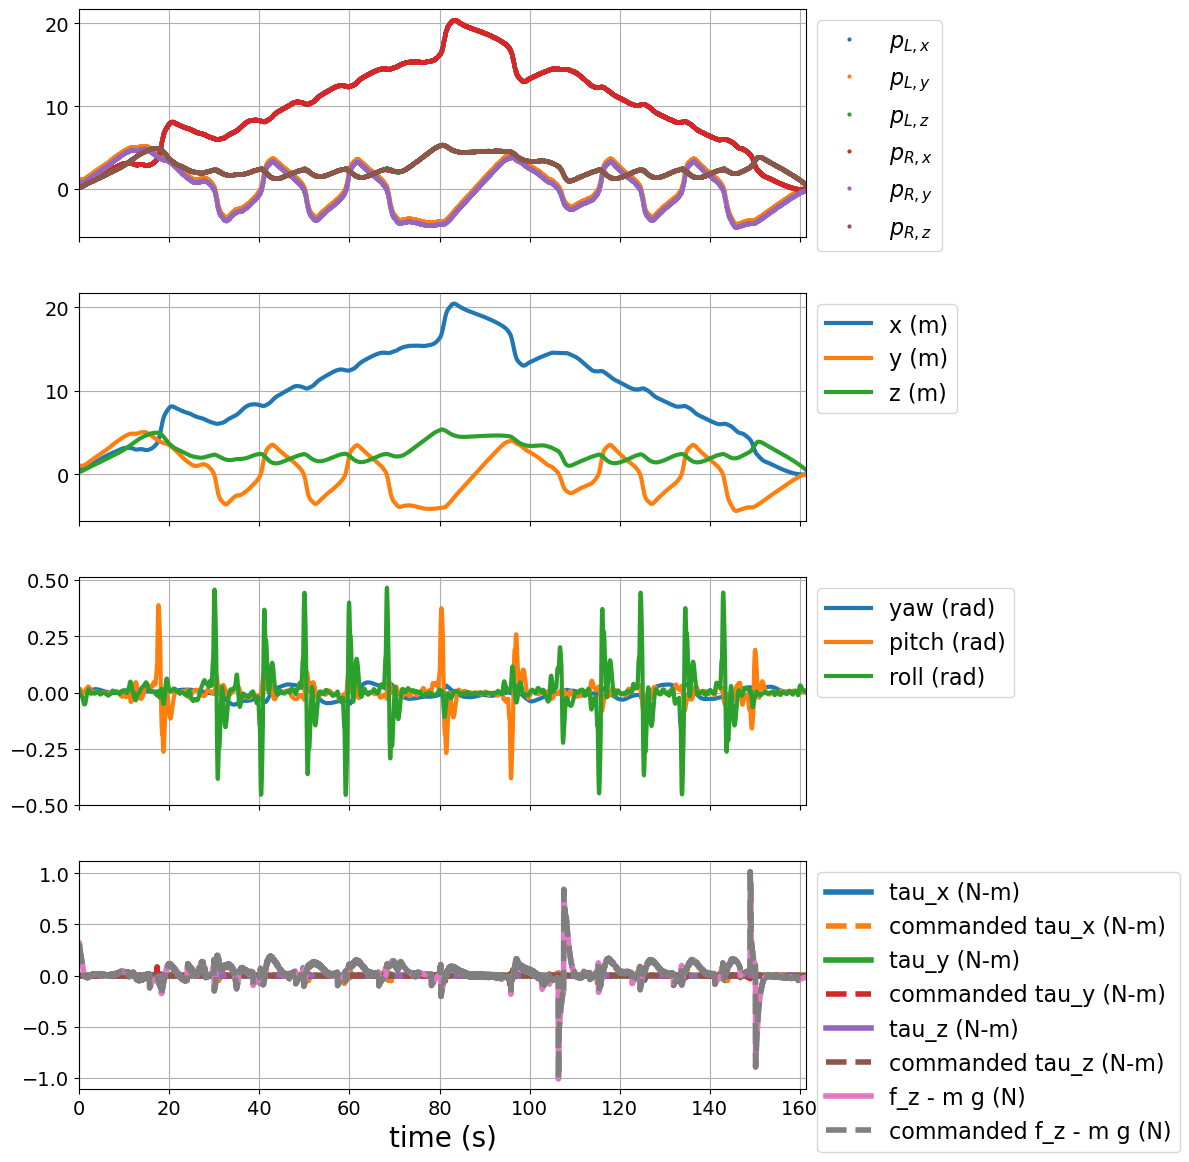

In [ ]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_meas, ax_pos, ax_ori, ax_act) = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Measurements
ax_meas.plot(data['t'], data['pos_markers'][:, 0], '.', markersize=4, label=r'$p_{L, x}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 1], '.', markersize=4, label=r'$p_{L, y}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 2], '.', markersize=4, label=r'$p_{L, z}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 3], '.', markersize=4, label=r'$p_{R, x}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 4], '.', markersize=4, label=r'$p_{R, y}$')
ax_meas.plot(data['t'], data['pos_markers'][:, 5], '.', markersize=4, label=r'$p_{R, z}$')
ax_meas.grid()
ax_meas.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_meas.tick_params(labelsize=14)

# Position
ax_pos.plot(data['t'], data['p_x'], label='x (m)', linewidth=3, color='C0')
ax_pos.plot(data['t'], data['p_y'], label='y (m)', linewidth=3, color='C1')
ax_pos.plot(data['t'], data['p_z'], label='z (m)', linewidth=3, color='C2')
ax_pos.grid()
ax_pos.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_pos.tick_params(labelsize=14)

# Orientation
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=3)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=3)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=3)
ax_ori.grid()
ax_ori.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_ori.tick_params(labelsize=14)

# Actuator commands
ax_act.plot(data['t'], data['tau_x'], label='tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_x_cmd'], '--', label='commanded tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y'], label='tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y_cmd'], '--', label='commanded tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z'], label='tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z_cmd'], '--', label='commanded tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['f_z'] - (0.5 * 9.81), label='f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.plot(data['t'], data['f_z_cmd'] - (0.5 * 9.81), '--', label='commanded f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.grid()
ax_act.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_act.tick_params(labelsize=14)

# Set shared x-axis properties
ax_act.set_xlabel('time (s)', fontsize=20)
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()

Plot histogram of controller run times.

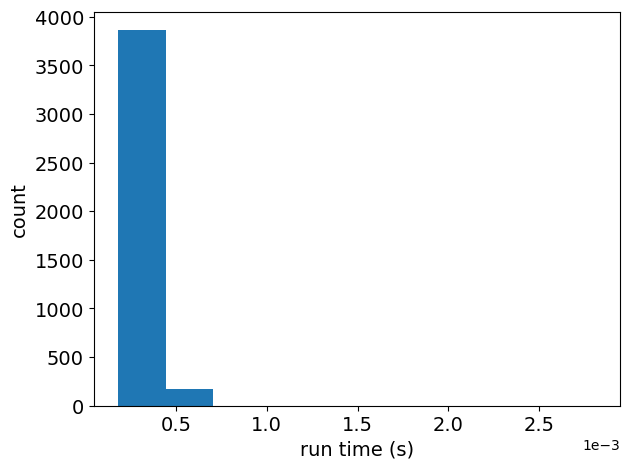

In [ ]:
plt.hist(data['run_time'])
plt.ticklabel_format(style='scientific', scilimits=(0, 0), axis='x')
plt.tick_params(labelsize=14)
plt.xlabel('run time (s)', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.tight_layout()
plt.show()

Note that it is required to also plot state estimates (in comparison to states) in order to check that your observer is working - no example is provided here, since no state estimates are being generated by the template `Controller` class.

argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=


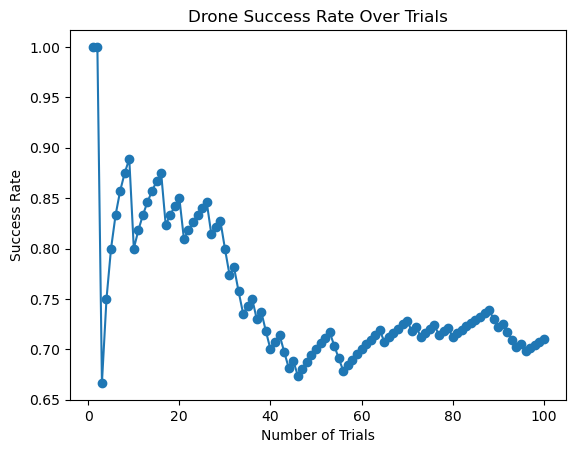

Final Success Rate: 71.00%


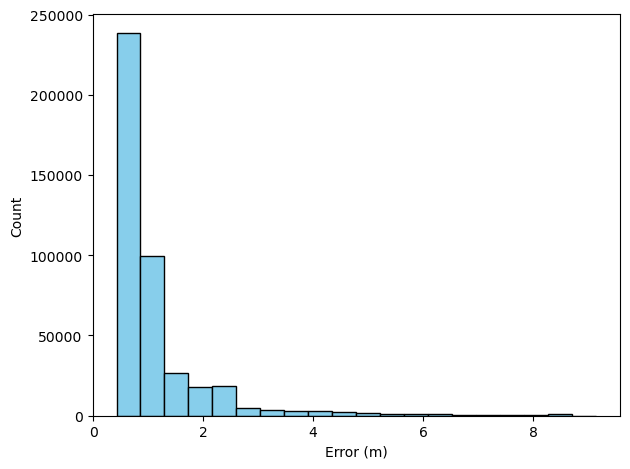

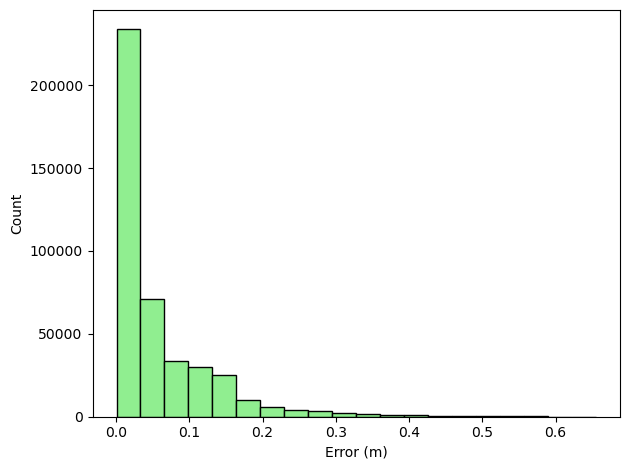

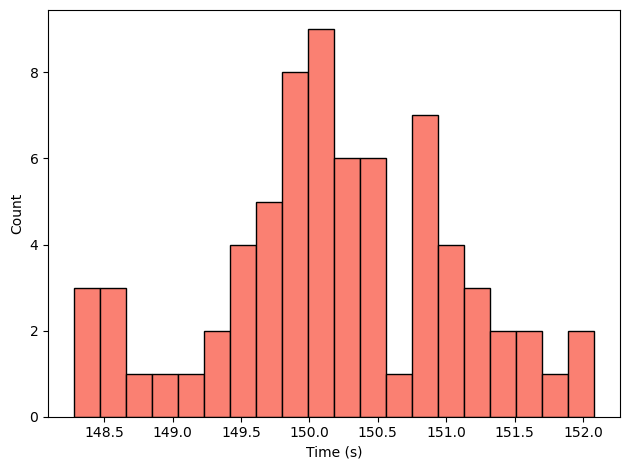

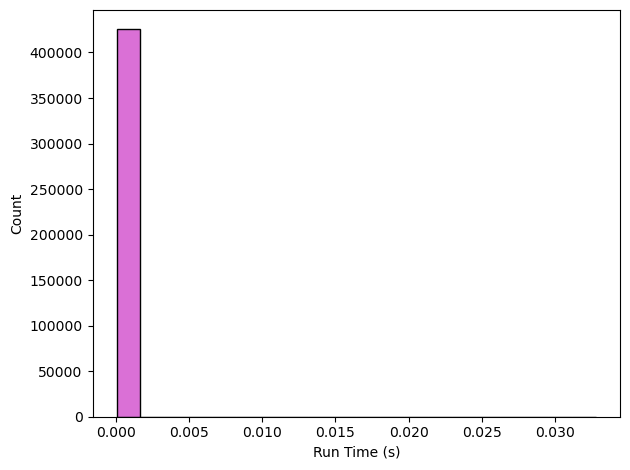


Out of 100 trials:
✅ Finished: 71
❌ Failed: 29
⏳ Timed out: 0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# === Storage for aggregate data ===
n_trials = 100
completion_times = []
position_errors = []
observer_errors = []
run_times = []
did_finish_list = []
did_fail_list = []
success_rate = []
trial_numbers = []

for trial in range(1, n_trials + 1):
    seed = np.random.randint(0, 2**32)
    simulator = ae353_drone.Simulator(seed=seed)
    simulator.disable_views()
    simulator.clear_drones()

    # Define LoggingController with tracking
    class LoggingController(Controller):
        def __init__(self):
            super().__init__()
            self.pos_err_log = []
            self.obs_err_log = []
            self.run_times = []

        def run(self, pos_markers, pos_ring, dir_ring, is_last_ring, pos_others):
            start = time.perf_counter()
            output = super().run(pos_markers, pos_ring, dir_ring, is_last_ring, pos_others)
            end = time.perf_counter()

            self.run_times.append(end - start)
            pos_actual = (pos_markers[:3] + pos_markers[3:]) / 2
            pos_des = self.x_des[:3]
            self.pos_err_log.append(np.linalg.norm(pos_actual - pos_des))
            self.obs_err_log.append(np.linalg.norm(self.xhat[:3] - pos_actual))
            return output

    # Add controller and drone
    ctrl = LoggingController()
    simulator.add_drone(lambda: ctrl, 'template', 'template.png')

    # Reset with initial conditions
    simulator.reset(initial_conditions={
        'template': {
            'p_x': 0., 'p_y': 0., 'p_z': 0.5,
            'yaw': 0., 'pitch': 0., 'roll': 0.,
            'v_x': 0., 'v_y': 0., 'v_z': 0.,
            'w_x': 0., 'w_y': 0., 'w_z': 0.,
            'p_x_meas': 0., 'p_y_meas': 0., 'p_z_meas': 0.5,
            'yaw_meas': 0.
        }
    })

    simulator.run(max_time=None, print_debug=False)

    result = simulator.get_result('template')
    if result is not None:
        did_fail, did_finish, finish_time = result
    else:
        did_fail, did_finish, finish_time = True, False, np.nan

    did_finish_list.append(did_finish)
    did_fail_list.append(did_fail)
    completion_times.append(finish_time if did_finish else np.nan)
    position_errors.extend(ctrl.pos_err_log)
    observer_errors.extend(ctrl.obs_err_log)
    run_times.extend(ctrl.run_times)

    trial_numbers.append(trial)
    successes_so_far = np.sum(did_finish_list)
    success_rate.append(successes_so_far / trial)

    if trial % 100 == 0:
        plt.figure(1)
        plt.clf()
        plt.plot(trial_numbers, success_rate, marker='o', linestyle='-')
        plt.xlabel("Number of Trials")
        plt.ylabel("Success Rate")
        plt.title("Drone Success Rate Over Trials")
        plt.pause(0.1)

# Final success rate
print(f"Final Success Rate: {success_rate[-1] * 100:.2f}%")
plt.show()

# === Plotting ===

# 1. Position Error
plt.figure()
plt.hist(position_errors, bins=20, color='skyblue', edgecolor='black')
#plt.title("Position Error (Actual vs Desired)")
plt.xlabel("Error (m)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2. Observer Error
plt.figure()
plt.hist(observer_errors, bins=20, color='lightgreen', edgecolor='black')
#plt.title("Observer Error (Estimate vs Actual)")
plt.xlabel("Error (m)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 3. Completion Times
plt.figure()
plt.hist([t for t in completion_times if not np.isnan(t)], bins=20, color='salmon', edgecolor='black')
#plt.title("Completion Times")
plt.xlabel("Time (s)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 4. Runtime per Step
plt.figure()
plt.hist(run_times, bins=20, color='orchid', edgecolor='black')
#plt.title("Controller Runtime per Step")
plt.xlabel("Run Time (s)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# === Summary ===
print(f"\nOut of {n_trials} trials:")
print(f"✅ Finished: {sum(did_finish_list)}")
print(f"❌ Failed: {sum(did_fail_list)}")
print(f"⏳ Timed out: {n_trials - sum(did_finish_list) - sum(did_fail_list)}")
